# Stochasic Processes in Python

by Stuart Reid (<a href="http://www.stuartreid.co.za">www.stuartreid.co.za</a>)

For more information about these stochastic and their applications in Quantitative Finance please check out my blog post, <a href="http://www.stuartreid.co.za/random-walks-down-wall-street-stochastic-processes-in-python/">Random Walks Down Wall Street, Stochastic Processes in Python</a>. This notebook contains the code presented in the article for four stochastic processes often used to model the evolution of asset prices and two mean-reverting stochastic processes often used to model the evolution of interest rates. Thes models include Brownian Motion (a Wiener Process), Geometric Brownian Motion, the Merton Jump Diffusion Model, the Heston Stochastic Volatility Model, the Cox Ingersoll Ross (CIR) process, and the Ornstein Uhlenbeck Model.

A random event is any event which has a chance of happening. Probability is the measure of that chance. Random variables are functions which receive a random event and return a real number. Random variables may be discrete or continuous; discrete random variables are ones with a countable number of possible outcomes; continuous random variables are ones which have an infinite number of possible outcomes. In the context of finance, a stochastic process is a collection of random variables which describe the evolution of a system over some period of time.

The beauty of random variables and stochastic processes is that they can be used to describe what is happening in the world around us. Often this is done by simulating multiple outcomes from a stochastic process in a Monte Carlo simulation. Example applications include the simulation of gambling games (Poker and Blackjack for sure), fluid and particle dynamics (which is often used in computer graphics for animations), in genetics to determine the likelihood of phylogenetic trees (how species relate), and even the evolution of stock prices and interest rates over time.

## Initial Setup

The initial setup involves importing some very helpful Python packages which we can use to generate and analyze random numbers, creating a model parameters class for encapsulating the parameter values for the stochastic processes, and some useful helper methods for working with log returns or normal returns

In [1]:
import math
import numpy
import random
import decimal
import scipy.linalg
import numpy.random as nrand
import matplotlib.pyplot as plt

##### The model parameters class

In [2]:
class ModelParameters:
    """
    Encapsulates model parameters
    """

    def __init__(self,
                 all_s0, all_time, all_delta, all_sigma, gbm_mu,
                 jumps_lamda=0.0, jumps_sigma=0.0, jumps_mu=0.0,
                 cir_a=0.0, cir_mu=0.0, all_r0=0.0, cir_rho=0.0,
                 ou_a=0.0, ou_mu=0.0,
                 heston_a=0.0, heston_mu=0.0, heston_vol0=0.0):
        # This is the starting asset value
        self.all_s0 = all_s0
        # This is the amount of time to simulate for
        self.all_time = all_time
        # This is the delta, the rate of time e.g. 1/252 = daily, 1/12 = monthly
        self.all_delta = all_delta
        # This is the volatility of the stochastic processes
        self.all_sigma = all_sigma
        # This is the annual drift factor for geometric brownian motion
        self.gbm_mu = gbm_mu
        # This is the probability of a jump happening at each point in time
        self.lamda = jumps_lamda
        # This is the volatility of the jump size
        self.jumps_sigma = jumps_sigma
        # This is the average jump size
        self.jumps_mu = jumps_mu
        # This is the rate of mean reversion for Cox Ingersoll Ross
        self.cir_a = cir_a
        # This is the long run average interest rate for Cox Ingersoll Ross
        self.cir_mu = cir_mu
        # This is the starting interest rate value
        self.all_r0 = all_r0
        # This is the correlation between the wiener processes of the Heston model
        self.cir_rho = cir_rho
        # This is the rate of mean reversion for Ornstein Uhlenbeck
        self.ou_a = ou_a
        # This is the long run average interest rate for Ornstein Uhlenbeck
        self.ou_mu = ou_mu
        # This is the rate of mean reversion for volatility in the Heston model
        self.heston_a = heston_a
        # This is the long run average volatility for the Heston model
        self.heston_mu = heston_mu
        # This is the starting volatility value for the Heston model
        self.heston_vol0 = heston_vol0


##### Example Usage

In [3]:
mp = ModelParameters(all_s0=1000,
                     all_r0=0.5,
                     all_time=800,
                     all_delta=0.00396825396,
                     all_sigma=0.125,
                     gbm_mu=0.058,
                     jumps_lamda=0.00125,
                     jumps_sigma=0.001,
                     jumps_mu=-0.2,
                     cir_a=3.0,
                     cir_mu=0.5,
                     cir_rho=0.5,
                     ou_a=3.0,
                     ou_mu=0.5,
                     heston_a=0.25,
                     heston_mu=0.35,
                     heston_vol0=0.06125)

paths = 15

##### A plotting helper class

In [4]:
def plot_stochastic_processes(processes, title):
    """
    This method plots a list of stochastic processes with a specified title
    :return: plots the graph of the two
    """
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(1)
    fig.suptitle(title, fontsize=16)
    ax.set_xlabel('Time, t')
    ax.set_ylabel('Simulated Asset Price')
    x_axis = numpy.arange(0, len(processes[0]), 1)
    for i in range(len(processes)):
        plt.plot(x_axis, processes[i])
    plt.show()

##### Two helper classes for working with returns

In [5]:
def convert_to_returns(log_returns):
    """
    This method exponentiates a sequence of log returns to get daily returns.
    :param log_returns: the log returns to exponentiated
    :return: the exponentiated returns
    """
    return numpy.exp(log_returns)


def convert_to_prices(param, log_returns):
    """
    This method converts a sequence of log returns into normal returns (exponentiation) and then computes a price
    sequence given a starting price, param.all_s0.
    :param param: the model parameters object
    :param log_returns: the log returns to exponentiated
    :return:
    """
    returns = convert_to_returns(log_returns)
    # A sequence of prices starting with param.all_s0
    price_sequence = [param.all_s0]
    for i in range(1, len(returns)):
        # Add the price at t-1 * return at t
        price_sequence.append(price_sequence[i - 1] * returns[i - 1])
    return numpy.array(price_sequence)

## <a href="http://en.wikipedia.org/wiki/Brownian_motion">Brownian Motion</a>

Brownian motion is the random motion exhibited by particles which have been suspended in a gas or liquid. This random motion is caused by the collision of the particles with the atoms or molecules in the liquid or gas. Brownian Motion is named after the Botanist Robert Brown who observed the random movements in 1827. The relationship between Brownian Motion and financial markets dates back to a paper written many years later, in 1900, by Louis Bachelier entitled The Theory of Speculation. His paper was the first to propose the use of Brownian Motion to evaluate stock options. The paper did not surface until later works in deriving the famous Black Scholes options pricing formula developed by Fisher Black and Myron Scholes in 1973. In the context of stochastic processes used in finance, Brownian Motion is often described as a Wiener process, denoted by $W_t$. A Wiener process is described by the following properties,

<ul>
    <li> $W_0 = 0$
    <li> The function $t - W_t$ is almost surely everywhere continuous
    <li> $W_t$ has independent normally distributed increments i.e. $W_t - W_s = N(0, t-s)$
</ul>

In [6]:
def brownian_motion_log_returns(param):
    """
    This method returns a Wiener process. The Wiener process is also called Brownian motion. For more information
    about the Wiener process check out the Wikipedia page: http://en.wikipedia.org/wiki/Wiener_process
    :param param: the model parameters object
    :return: brownian motion log returns
    """
    sqrt_delta_sigma = math.sqrt(param.all_delta) * param.all_sigma
    return nrand.normal(loc=0, scale=sqrt_delta_sigma, size=param.all_time)

def brownian_motion_levels(param):
    """
    Returns a price sequence whose returns evolve according to a brownian motion
    :param param: model parameters object
    :return: returns a price sequence which follows a brownian motion
    """
    return convert_to_prices(param, brownian_motion_log_returns(param))

##### Example usage

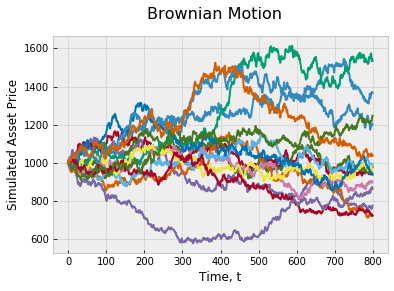

In [8]:
brownian_motion_examples = []
for i in range(paths):
    brownian_motion_examples.append(brownian_motion_levels(mp))
plot_stochastic_processes(brownian_motion_examples, "Brownian Motion")

## <a href="http://en.wikipedia.org/wiki/Geometric_Brownian_motion">Geometric Brownian Motion</a>

Geometric Brownian Motion (GBM) was popularized by Fisher Black and Myron Scholes when they used it in their 1973 paper, The Pricing of Options and Corporate Liabilities, to derive the Black Scholes equation. Geometric Brownian Motion is essentially Brownian Motion with a drift component and volatility component. The stochastic differential equation which describes the evolution of a Geometric Brownian Motion stochastic process is,

$$dS_t = \mu S_t dt + \sigma d S_t W_t$$

where $dS_t$ is the change in the asset price, $S$, at time $t$; $\mu$ is the percentage drift expected per annum, $dt$, represents time (1/252 is used for daily changes), $\sigma$ is the daily volatility expected in the asset prices, and $W_t$ is a Wiener process a.k.a Brownian Motion.

In [12]:
def geometric_brownian_motion_log_returns(param):
    """
    This method constructs a sequence of log returns which, when exponentiated, produce a random Geometric Brownian
    Motion (GBM). GBM is the stochastic process underlying the Black Scholes options pricing formula.
    :param param: model parameters object
    :return: returns the log returns of a geometric brownian motion process
    """
    assert isinstance(param, ModelParameters)
    wiener_process = numpy.array(brownian_motion_log_returns(param))
    sigma_pow_mu_delta = (param.gbm_mu - 0.5 * math.pow(param.all_sigma, 2.0)) * param.all_delta
    return wiener_process + sigma_pow_mu_delta

def geometric_brownian_motion_levels(param):
    """
    Returns a sequence of price levels for an asset which evolves according to a geometric brownian motion
    :param param: model parameters object
    :return: the price levels for the asset
    """
    return convert_to_prices(param, geometric_brownian_motion_log_returns(param))

##### Example usage

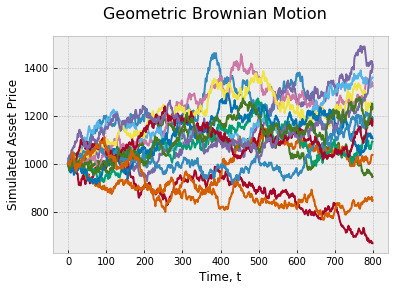

In [13]:
geometric_brownian_motion_examples = []
for i in range(paths):
    geometric_brownian_motion_examples.append(geometric_brownian_motion_levels(mp))
plot_stochastic_processes(geometric_brownian_motion_examples, "Geometric Brownian Motion")

## <a href="http://en.wikipedia.org/wiki/Jump_diffusion">The Merton Jump Diffusion Model</a>

Robert C. Merton was one of the first academics to address some of the limitations in the Geometric Brownian Stochastic Process presented by Fisher Black and Myron Scholes. In  1997 Merton and Scholes won a Nobel Price in Economics for their work; Black had unfortunately passed away at that point in time. One of the stochastic processes proposed by Merton addressed the impossibility of a discontinuity occurring in the continuous Geometric Brownian Motion model.

Merton extended the original Geometric Brownian Motion process with a Jump Diffusion process in his 1976 paper, Option pricing when underlying stock returns are discontinuous. For an in-depth discussion on the mathematics underlying Jump Diffusion processes please see, an Introduction to Diffusion and Jump Diffusion Processes but in summary the stochastic process adds a jump process such as a compound Poisson process to an underlying diffusion process such as Geometric Brownian Motion. In the code below the jump component is called jump_sizes,

$$dS_t = \mu S_t dt + \sigma S_t d W_t + dJ_t$$
$$dJ_t = S_t d(\sum^{N_t}_{i=0}(Y_i-1))$$

where $N_t$ is the Poisson process with rate $\lambda$ and $Y_i$ is a random variable which follows a log-normal distribution.

In [10]:
def jump_diffusion_process(param):
    """
    This method produces a sequence of Jump Sizes which represent a jump diffusion process. These jumps are combined
    with a geometric brownian motion (log returns) to produce the Merton model.
    :param param: the model parameters object
    :return: jump sizes for each point in time (mostly zeroes if jumps are infrequent)
    """
    assert isinstance(param, ModelParameters)
    s_n = time = 0
    small_lamda = -(1.0 / param.lamda)
    jump_sizes = []
    for k in range(0, param.all_time):
        jump_sizes.append(0.0)
    while s_n < param.all_time:
        s_n += small_lamda * math.log(random.uniform(0, 1))
        for j in range(0, param.all_time):
            if time * param.all_delta <= s_n * param.all_delta <= (j + 1) * param.all_delta:
                # print("was true")
                jump_sizes[j] += random.normalvariate(param.jumps_mu, param.jumps_sigma)
                break
        time += 1
    return jump_sizes

def geometric_brownian_motion_jump_diffusion_log_returns(param):
    """
    This method constructs combines a geometric brownian motion process (log returns) with a jump diffusion process
    (log returns) to produce a sequence of gbm jump returns.
    :param param: model parameters object
    :return: returns a GBM process with jumps in it
    """
    assert isinstance(param, ModelParameters)
    jump_diffusion = jump_diffusion_process(param)
    geometric_brownian_motion = geometric_brownian_motion_log_returns(param)
    return numpy.add(jump_diffusion, geometric_brownian_motion)


def geometric_brownian_motion_jump_diffusion_levels(param):
    """
    This method converts a sequence of gbm jmp returns into a price sequence which evolves according to a geometric
    brownian motion but can contain jumps at any point in time.
    :param param: model parameters object
    :return: the price levels
    """
    return convert_to_prices(param, geometric_brownian_motion_jump_diffusion_log_returns(param))

##### Example usage

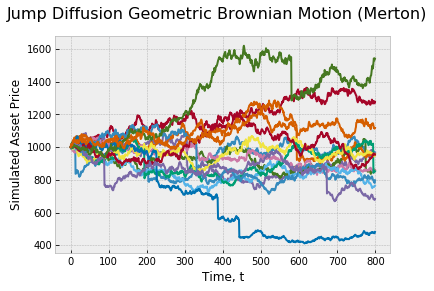

In [18]:
jump_diffusion_examples = []
for i in range(paths):
    jump_diffusion_examples.append(geometric_brownian_motion_jump_diffusion_levels(mp))
plot_stochastic_processes(jump_diffusion_examples, "Jump Diffusion Geometric Brownian Motion (Merton)")

## <a href="http://en.wikipedia.org/wiki/Heston_model">The Heston Stochastic Volatility Model</a>

The original Geometric Brownian Motion stochastic process assumes that volatility over time is constant. In the early 1990's Steven Heston relaxed this assumption and extended the Geometric Brownian Motion model to include stochastic volatility. The resulting model is called the Heston model. In the Heston model volatility over time evolves over time according to the Cox Ingersoll Ross stochastic process. As such the model makes use to two Wiener processes, one for the Cox Ingersoll Ross process and another for the Geometric Brownian Motion process which uses the Cox Ingersoll Ross process as volatility. These two Wiener processes are correlated and can be constructed using a Cholesky Decomposition. The stochastic differential equation for the Heston model is given as,

$$dS_t = \mu S_t dt + \sqrt{v_t}S_t d W^S_t$$
$$dv_t = a(b-v_t)dt + \sigma\sqrt{v_t} d W^v_t$$

where $\mu$ is the drift of the asset, $S^S$ and $W^v$ are two correlated Wiener processes where the correlation is given by $\rho$, $a$ is the rate of mean-reversion of the Cox Ingersoll Ross process, $b$ is the mean value over time (in this case the mean volatility over time), and $\sigma$ is the volatility of the Cox Ingersoll Ross process. 

The term, $a(b−vt)$ is also called the drift factor.

##### Correlated Wiener Processes

In [14]:
def heston_construct_correlated_path(param, brownian_motion_one):
    """
    This method is a simplified version of the Cholesky decomposition method for just two assets. It does not make use
    of matrix algebra and is therefore quite easy to implement.
    :param param: model parameters object
    :return: a correlated brownian motion path
    """
    # We do not multiply by sigma here, we do that in the Heston model
    sqrt_delta = math.sqrt(param.all_delta)
    # Construct a path correlated to the first path
    brownian_motion_two = []
    for i in range(param.all_time - 1):
        term_one = param.cir_rho * brownian_motion_one[i]
        term_two = math.sqrt(1 - math.pow(param.cir_rho, 2.0)) * random.normalvariate(0, sqrt_delta)
        brownian_motion_two.append(term_one + term_two)
    return numpy.array(brownian_motion_one), numpy.array(brownian_motion_two)

def get_correlated_geometric_brownian_motions(param, correlation_matrix, n):
    """
    This method can construct a basket of correlated asset paths using the Cholesky decomposition method
    :param param: model parameters object
    :param correlation_matrix: nxn correlation matrix
    :param n: the number of assets i.e. the number of paths to return
    :return: n correlated log return geometric brownian motion processes
    """
    assert isinstance(param, ModelParameters)
    decomposition = scipy.linalg.cholesky(correlation_matrix, lower=False)
    uncorrelated_paths = []
    sqrt_delta_sigma = math.sqrt(param.all_delta) * param.all_sigma
    # Construct uncorrelated paths to convert into correlated paths
    for i in range(param.all_time):
        uncorrelated_random_numbers = []
        for j in range(n):
            uncorrelated_random_numbers.append(random.normalvariate(0, sqrt_delta_sigma))
        uncorrelated_paths.append(numpy.array(uncorrelated_random_numbers))
    uncorrelated_matrix = numpy.matrix(uncorrelated_paths)
    correlated_matrix = uncorrelated_matrix * decomposition
    assert isinstance(correlated_matrix, numpy.matrix)
    # The rest of this method just extracts paths from the matrix
    extracted_paths = []
    for i in range(1, n + 1):
        extracted_paths.append([])
    for j in range(0, len(correlated_matrix)*n - n, n):
        for i in range(n):
            extracted_paths[i].append(correlated_matrix.item(j + i))
    return extracted_paths

The following code is used to construct the volatility path

In [15]:
def cox_ingersoll_ross_heston(param):
    """
    This method returns the rate levels of a mean-reverting cox ingersoll ross process. It is used to model interest
    rates as well as stochastic volatility in the Heston model. Because the returns between the underlying and the
    stochastic volatility should be correlated we pass a correlated Brownian motion process into the method from which
    the interest rate levels are constructed. The other correlated process is used in the Heston model
    :param param: the model parameters objects
    :return: the interest rate levels for the CIR process
    """
    # We don't multiply by sigma here because we do that in heston
    sqrt_delta_sigma = math.sqrt(param.all_delta) * param.all_sigma
    brownian_motion_volatility = nrand.normal(loc=0, scale=sqrt_delta_sigma, size=param.all_time)
    a, mu, zero = param.heston_a, param.heston_mu, param.heston_vol0
    volatilities = [zero]
    for i in range(1, param.all_time):
        drift = a * (mu - volatilities[i-1]) * param.all_delta
        randomness = math.sqrt(max(volatilities[i - 1], 0.05)) * brownian_motion_volatility[i - 1]
        volatilities.append(max(volatilities[i - 1], 0.05) + drift + randomness)
    return numpy.array(brownian_motion_volatility), numpy.array(volatilities)

The following code is used to construct the asset price levels

In [16]:
def heston_model_levels(param):
    """
    NOTE - this method is dodgy! Need to debug!
    The Heston model is the geometric brownian motion model with stochastic volatility. This stochastic volatility is
    given by the cox ingersoll ross process. Step one on this method is to construct two correlated GBM processes. One
    is used for the underlying asset prices and the other is used for the stochastic volatility levels
    :param param: model parameters object
    :return: the prices for an underlying following a Heston process
    """
    assert isinstance(param, ModelParameters)
    # Get two correlated brownian motion sequences for the volatility parameter and the underlying asset
    # brownian_motion_market, brownian_motion_vol = get_correlated_paths_simple(param)
    brownian, cir_process = cox_ingersoll_ross_heston(param)
    brownian, brownian_motion_market = heston_construct_correlated_path(param, brownian)

    heston_market_price_levels = [param.all_s0]
    for i in range(1, param.all_time):
        drift = param.gbm_mu * heston_market_price_levels[i - 1] * param.all_delta
        vol = cir_process[i - 1] * heston_market_price_levels[i - 1] * brownian_motion_market[i - 1]
        heston_market_price_levels.append(heston_market_price_levels[i - 1] + drift + vol)
    return numpy.array(heston_market_price_levels), numpy.array(cir_process)

##### Example usage - price levels

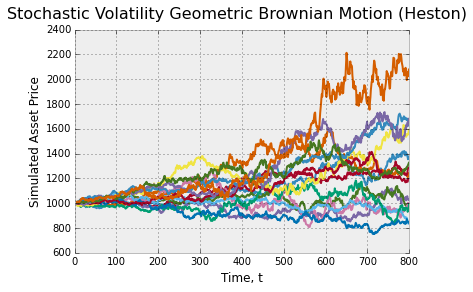

In [17]:
stochastic_volatility_examples = []
for i in range(paths):
    stochastic_volatility_examples.append(heston_model_levels(mp)[0])
plot_stochastic_processes(stochastic_volatility_examples, "Stochastic Volatility Geometric Brownian Motion (Heston)")

##### Example usage - volatility levels

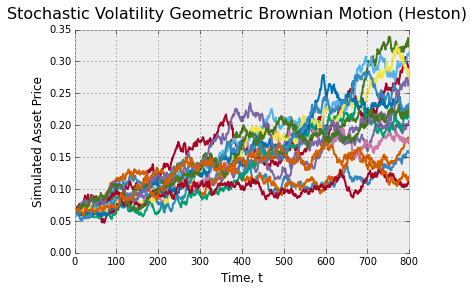

In [18]:
stochastic_volatility_examples = []
for i in range(paths):
    stochastic_volatility_examples.append(heston_model_levels(mp)[1])
plot_stochastic_processes(stochastic_volatility_examples, "Stochastic Volatility Geometric Brownian Motion (Heston)")

## <a href="http://en.wikipedia.org/wiki/Cox%E2%80%93Ingersoll%E2%80%93Ross_model">Cox Ingersoll Ross</a>

The Cox Ingersoll Ross (CIR) stochastic process is used to describe the evolution of interest rates over time. The CIR stochastic process was first introduced in 1985 by John Cox, Johnathan Ingersoll, and Stephen Ross. The CIR process is an extension of the Ornstein Uhlenbeck stochastic process. The stochastic process is often used in the valuation of interest rate derivatives and has been used in the Heston model to describe the evolution of volatility over time. One interesting characteristic of the CIR stochastic process is that it is mean-reverting. Mean reversion is the phenomena whereby a level tends to move towards the average level over time. In other words, if the average interest rate is 0.5%, and we simulate 500 independent CIR processes, we would expect the average interest rate at the end of the projection period to be approximately 0.5%. The stochastic differential equation for the CIR process is given by,

$$d r_t = a(b - r_t)dt + \sigma \sqrt{r_t} d W_t$$

where $W_t$ is a Wiener process, $a$ is the rate at which the process mean reverts (a larger number results in a faster mean reverting process), $b$ is the long run average interest rate, and $\sigma$ is the volatility of the process. The code for the CIR stochastic process is given below.

In [19]:
def cox_ingersoll_ross_levels(param):
    """
    This method returns the rate levels of a mean-reverting cox ingersoll ross process. It is used to model interest
    rates as well as stochastic volatility in the Heston model. Because the returns between the underlying and the
    stochastic volatility should be correlated we pass a correlated Brownian motion process into the method from which
    the interest rate levels are constructed. The other correlated process is used in the Heston model
    :param param: the model parameters object
    :return: the interest rate levels for the CIR process
    """
    brownian_motion = brownian_motion_log_returns(param)
    # Setup the parameters for interest rates
    a, mu, zero = param.cir_a, param.cir_mu, param.all_r0
    # Assumes output is in levels
    levels = [zero]
    for i in range(1, param.all_time):
        drift = a * (mu - levels[i-1]) * param.all_delta
        # The main difference between this and the Ornstein Uhlenbeck model is that we multiply the 'random'
        # component by the square-root of the previous level i.e. the process has level dependent interest rates.
        randomness = math.sqrt(levels[i - 1]) * brownian_motion[i - 1]
        levels.append(levels[i - 1] + drift + randomness)
    return numpy.array(levels)

##### Example usage

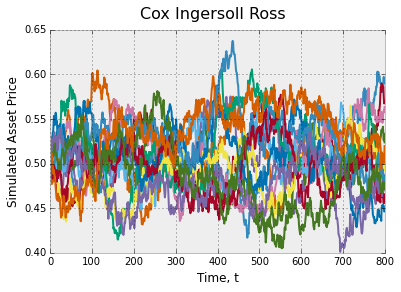

In [20]:
cir_examples = []
for i in range(paths):
    cir_examples.append(cox_ingersoll_ross_levels(mp))
plot_stochastic_processes(cir_examples, "Cox Ingersoll Ross")

## <a href="http://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process">Ornstein Uhlenbeck</a>

The Ornstein Uhlebneck stochastic process is another mean-reverting process which is sometimes used for modelling interest rates. The Ornstein Uhlenbeck process is named after Leonard Ornstein and George Eugene Uhlenbeck. The difference between the Ornstein Uhlenbeck stochastic process and the CIR process is that the CIR processes multiplies the stochastic component by the square root of the previous value for the interest rate. The stochastic differential equation for the Ornstein Uhlenbeck process is,

$$d r_t = a(b - r_t)dt + \sigma r_t d W_t$$

where $W_t$ is a Wiener process, $a$ is the rate at which the process mean reverts (a larger number results in a faster mean reverting process), $b$ is the long run average interest rate, and $\sigma$ is the volatility of the process. The code for the Ornstein Uhlenbeck stochastic process is given below.

In [21]:
def ornstein_uhlenbeck_levels(param):
    """
    This method returns the rate levels of a mean-reverting ornstein uhlenbeck process.
    :param param: the model parameters object
    :return: the interest rate levels for the Ornstein Uhlenbeck process
    """
    ou_levels = [param.all_r0]
    brownian_motion_returns = brownian_motion_log_returns(param)
    for i in range(1, param.all_time):
        drift = param.ou_a * (param.ou_mu - ou_levels[i-1]) * param.all_delta
        randomness = brownian_motion_returns[i - 1]
        ou_levels.append(ou_levels[i - 1] + drift + randomness)
    return ou_levels

##### Example Usage

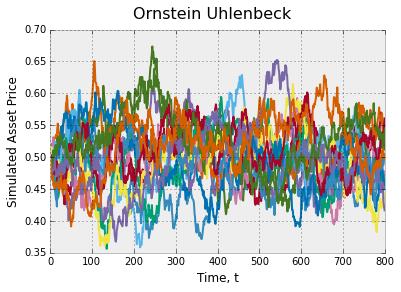

In [22]:
ou_examples = []
for i in range(paths):
    ou_examples.append(ornstein_uhlenbeck_levels(mp))
plot_stochastic_processes(ou_examples, "Ornstein Uhlenbeck")

## Conclusion and further work

For more information about these stochastic and their applications in Quantitative Finance please check out my blog post, <a href="http://www.stuartreid.co.za/random-walks-down-wall-street-stochastic-processes-in-python/">Random Walks Down Wall Street, Stochastic Processes in Python</a>. Stochastic processes are useful for describing the random processes we find in the world around us. They are used in engineering, genetics, physics, and in quantitative finance. Quants use stochastic processes to project possible returns in markets and changes in interest rates over time. Stochastic processes are often used in conjunction with Monte Carlo methods to derive fair values for over the counter derivatives.